<a href="https://colab.research.google.com/github/bghadge/Computer-Vision/blob/master/05_Scene_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 PS5: Scene Recognition




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [0]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-02-15 14:59:57--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  11.2MB/s    in 46s     

2020-02-15 15:00:44 (11.0 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [0]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [0]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_path = './data_miniplaces_modified/train/'
    test_path = './data_miniplaces_modified/test/'
    val_path = './data_miniplaces_modified/val/'

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I. Resize the image to input_size using transforms.Resize
    # II. Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations.

    data_transform = transforms.Compose([
                                          transforms.Resize(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean,std)
                                        ])
    

    # ========= Step 2: build dataloaders for the downloaded data ===========
    # I. use torchvision.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to construct pytorch datasets for train/val/test 
    train_image = torchvision.datasets.ImageFolder(root=train_path, transform=data_transform)
    test_image = torchvision.datasets.ImageFolder(root=test_path, transform=data_transform)
    val_image = torchvision.datasets.ImageFolder(root=val_path, transform=data_transform)

    # II. use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    train_data = torch.utils.data.DataLoader(train_image, batch_size=batch_size, shuffle=True, num_workers=2)
    test_data = torch.utils.data.DataLoader(test_image, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    val_data = torch.utils.data.DataLoader(val_image, batch_size=batch_size, shuffle=shuffle, num_workers=2)

    # III. put the dataloaders into a dictionary
    dataloaders_dict = {'train': train_data, 'test': test_data, 'val': val_data}
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return dataloaders_dict

In [0]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


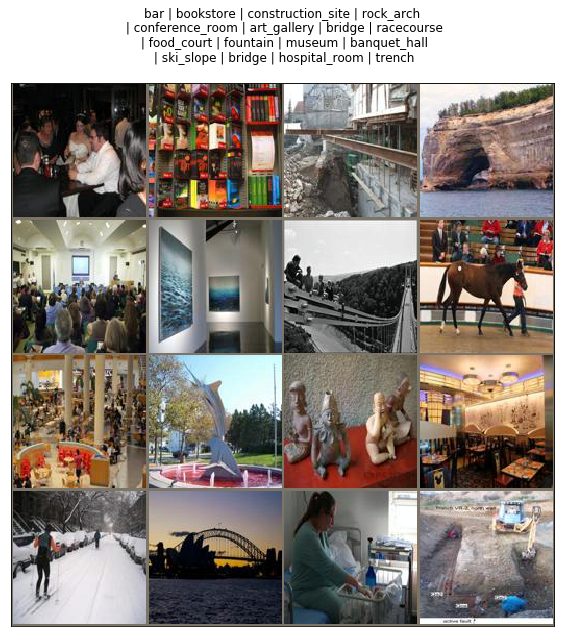

In [0]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [0]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [0]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers before the fully-connected layers in the VGG11 network. 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    if batch_norm==False:
      features = nn.Sequential(
                                nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False),
                                nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False),
                                nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False)
                              )
    else:
      features = nn.Sequential(
                                nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False),
                                nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False),
                                nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,ceil_mode=False)
                              )

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        # Construct the final FC layers using nn.Sequential. 
        self.classifier = nn.Sequential(
                                          nn.Linear(in_features=3200, out_features=512, bias=True),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3, inplace=False),
                                          nn.Linear(in_features=512, out_features=256, bias=True),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3, inplace=False),
                                          nn.Linear(in_features=256, out_features=100, bias=True)
                                        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [0]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [0]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    # Create an Adam optimizer with a learning rate 1e-3
    optimizer = optim.Adam(model.parameters() , lr=1e-3)

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    # Create an instance of the cross entropy loss function
    # The code should be a one-liner.
    criterion = nn.CrossEntropyLoss()

    return criterion

In [0]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    # best_model_wts = model.state_dict(torch.load('./weights/MiniVGG.pth'))
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # For "train" phase, compute the outputs, calculate the loss, update the model parameters
                # For "val" phase, compute the outputs, calculate the loss
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                  # torch.autograd.set_detect_anomaly(True)
                  loss.backward()
                  optimizer.step()


                # statistics
                running_loss = running_loss + loss.item() * inputs.size(0)
                _, preds = torch.max(outputs.data, 1)
                running_corrects = running_corrects + torch.sum(preds == labels.data) #preds = max(outputs)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [0]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [0]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.0721 Acc: 0.0633


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6709 Acc: 0.1201
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5128 Acc: 0.1482


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2952 Acc: 0.1891
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2598 Acc: 0.1935


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1225 Acc: 0.2208
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0845 Acc: 0.2278


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0814 Acc: 0.2375
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9481 Acc: 0.2536


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9172 Acc: 0.2675
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8292 Acc: 0.2759


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9017 Acc: 0.2695
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7266 Acc: 0.2965


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8640 Acc: 0.2775
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6292 Acc: 0.3142


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8200 Acc: 0.2858
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5330 Acc: 0.3333


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8303 Acc: 0.2920
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4425 Acc: 0.3503


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8378 Acc: 0.2972
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3523 Acc: 0.3691


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8394 Acc: 0.2945
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2761 Acc: 0.3831


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8516 Acc: 0.2963
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2004 Acc: 0.4007


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9051 Acc: 0.2972
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1192 Acc: 0.4179


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9104 Acc: 0.2943
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0508 Acc: 0.4322


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9640 Acc: 0.2905
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9779 Acc: 0.4448


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0405 Acc: 0.2886
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9208 Acc: 0.4587


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0712 Acc: 0.2795
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8607 Acc: 0.4740


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1150 Acc: 0.2834
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7967 Acc: 0.4859


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1251 Acc: 0.2827
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7495 Acc: 0.4960


100%|██████████| 79/79 [00:07<00:00, 10.85it/s]

val Loss: 3.1970 Acc: 0.2811
Best val Acc: 0.297200


In [0]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.9117 Acc: 0.0857


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6769 Acc: 0.1250
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.4954 Acc: 0.1485


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.4052 Acc: 0.1681
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3133 Acc: 0.1829


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2444 Acc: 0.2014
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1893 Acc: 0.2053


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0149 Acc: 0.2332
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0804 Acc: 0.2263


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0013 Acc: 0.2421
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9854 Acc: 0.2442


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9612 Acc: 0.2548
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9095 Acc: 0.2611


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7991 Acc: 0.2901
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8347 Acc: 0.2761


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8585 Acc: 0.2776
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7647 Acc: 0.2896


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7290 Acc: 0.3050
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6868 Acc: 0.3046


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7355 Acc: 0.2993
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6300 Acc: 0.3160


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6723 Acc: 0.3172
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5659 Acc: 0.3296


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6395 Acc: 0.3275
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5055 Acc: 0.3408


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5910 Acc: 0.3324
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4468 Acc: 0.3536


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5602 Acc: 0.3423
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3943 Acc: 0.3641


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5834 Acc: 0.3347
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3359 Acc: 0.3753


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6289 Acc: 0.3345
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2937 Acc: 0.3864


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5424 Acc: 0.3489
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2297 Acc: 0.3979


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5589 Acc: 0.3468
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1801 Acc: 0.4087


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5657 Acc: 0.3502
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1335 Acc: 0.4179


100%|██████████| 79/79 [00:07<00:00, 10.59it/s]

val Loss: 2.5778 Acc: 0.3433
Best val Acc: 0.350200


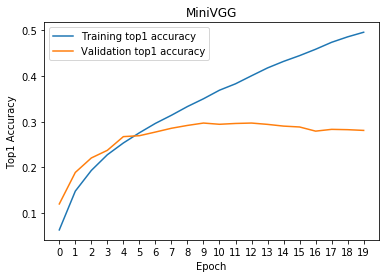

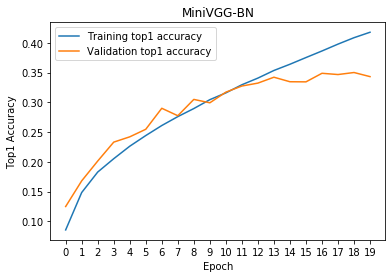

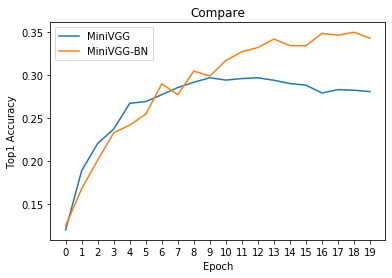

In [0]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Please write a few sentences here to summarize the effect of batch nomalization.

Answer:

MiniVGG-BN takes lesser number of epochs to reach same accuracy as MiniVGG. It stabilizes the learning process(function) by using the mean and variance of each batch rather than considering every sample. This increases its top1 and top5 accuracy.


## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [0]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [0]:
##### To pass the test, both networks should have Top-5 accuracy above 50% #####
# uncomment these two lines to load pretrained weights
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 34.84%, Top-5 accuracy 64.69%
Top-1 accuracy 29.51%, Top-5 accuracy 59.22%
